In [3]:
import numpy as np
import matplotlib.pyplot as plt
from simpegEMIP import getTau, DebyeDecProblem, DebyeDecSurvey
%matplotlib inline

def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

In [4]:
taumin, taumax = 1e-8, 1e8
ntau = 81
mesh = getTau(taumin, taumax, ntau)
frequency = np.logspace(-8, 8, 81)
itau = 20

In [5]:
from SimPEG import (DataMisfit, Regularization, Inversion,
                    Optimization, InvProblem, Directives)
wires = Maps.Wires(('sigmaInf', 1), ('eta', mesh.nN))
sigmaInf, tau, c = 0.01, 0.001, 0.5
sigmap = Maps.ExpMap(nP=1)*wires.sigmaInf
# sigmap = wires.sigmaInf
prb = DebyeDecProblem(mesh, sigmaInfMap = sigmap, etaMap = wires.eta, frequency=frequency)
survey = DebyeDecSurvey()
prb.pair(survey)
# f = prb.fields(m)
# d = survey.dpred(m)
dobs = ColeColePelton(prb.frequency, sigmaInf, 0.1, tau, c) 
survey.dobs = np.r_[np.log(dobs).real, np.log(dobs).imag]
m0 = np.r_[survey.dobs[prb.nfreq-1], np.zeros(prb.ntau)+1e-10]
survey.std = 0.
survey.eps = np.r_[abs(np.ones(prb.nfreq)*np.log(dobs[prb.nfreq-1]).real)*0.01, np.ones(prb.nfreq)*1e-4]
regmesh = Mesh.TensorMesh([m0.size])
# Now set up the problem to do some minimization
dmis = DataMisfit.l2_DataMisfit(survey)
target = Directives.TargetMisfit()
reg = Regularization.BaseRegularization(regmesh)
opt = Optimization.InexactGaussNewton(
    maxIterLS=20, maxIter=20, tolF=1e-6,
    tolX=1e-6, tolG=1e-6, maxIterCG=6
)
beta = Directives.BetaSchedule()
opt.upper = np.r_[np.log(1e2), 1.*np.ones(prb.ntau)]
opt.lower = np.r_[np.log(1e-6), 0.*np.ones(prb.ntau)]
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e1)
inv = Inversion.BaseInversion(invProb, directiveList=[target])
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  2.59e+05  0.00e+00  2.59e+05    1.67e+04      0              
   1  1.00e+01  1.22e+05  1.04e-04  1.22e+05    1.10e+03      0              
   2  1.00e+01  6.79e+03  2.10e-04  6.79e+03    3.71e+01      0              
   3  1.00e+01  1.23e+02  2.32e-04  1.23e+02    7.20e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.5872e-01
0 : |xc-x_last| = 8.3189e-04 <= tolX*(1+|x0|) = 5.6053e-06
0 : |proj(x-g)-x|    = 7.2032e+00 <= 

In [103]:
# plt.plot(survey.dobs, 'k')
# plt.plot(survey.dpred(mopt), 'r')

In [104]:
(abs(survey.dobs-invProb.dpred) / (survey.std*abs(survey.dobs)+survey.eps)).sum()

35.918445746290857

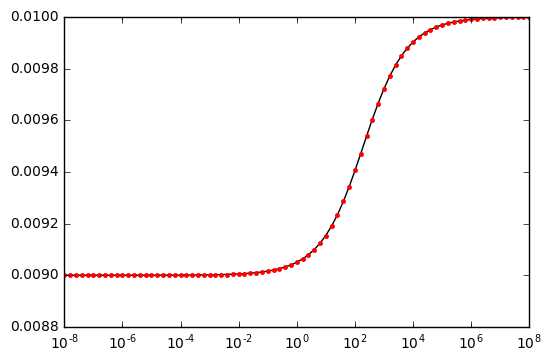

In [105]:
plt.semilogx(prb.frequency, np.exp(survey.dobs[:prb.nfreq]), 'k')
plt.semilogx(prb.frequency, np.exp(invProb.dpred[:prb.nfreq]), 'r.')

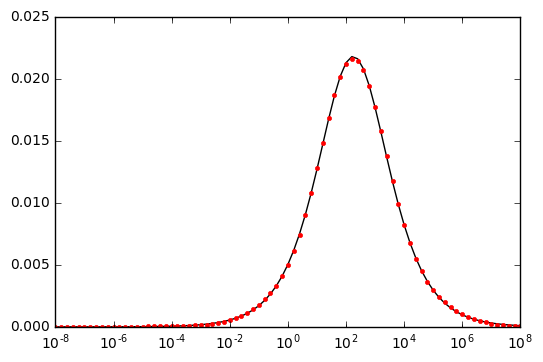

In [106]:
plt.semilogx(prb.frequency, survey.dobs[prb.nfreq:], 'k')
plt.semilogx(prb.frequency, invProb.dpred[prb.nfreq:], 'r.')

0.00999855640261


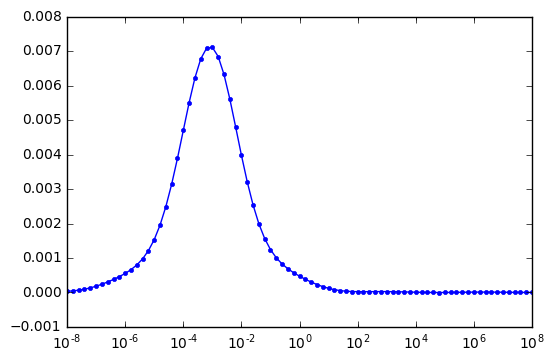

In [107]:
print np.exp(mopt[0])
plt.semilogx(prb.tau, mopt[1:], '.-')

In [108]:
# mx = np.zeros_like(prb.eta)
# mx[20] = 1.
# out = Jvec(prb.eta, mx)
# plt.plot(dsigdeta(prb.eta[20], prb.tau[20], prb.omega).real)
# plt.plot(out.real, 'k.')

In [109]:
# sigma_prb = prb.fields()
# plt.semilogx(prb.f, np.log(sigma_prb).real, 'k.-')
# plt.semilogx(prb.f, np.log(sigma_prb).imag, 'r.-')
# plt.grid(True)
# ymin, ymax = plt.gca().get_ylim()
# plt.plot(np.ones(2)*1./(2*np.pi*tau), np.r_[ymin, ymax], 'k-')
# plt.ylim(ymin, ymax)

In [110]:
# sigma = ColeColePelton(f, sigmaInf, 0.1, tau, c)
# etatilde = (sigma-sigmaInf)/sigmaInf

In [13]:
# np.linalg.norm(sigma_prb-sigma)

In [14]:
# plt.semilogx(f, np.log(sigma/sigmaInf).real, 'k.-')
# plt.semilogx(f, np.log(sigma).imag, 'r.-')
# plt.grid(True)
# ymin, ymax = plt.gca().get_ylim()
# plt.plot(np.ones(2)*1./(2*np.pi*tau), np.r_[ymin, ymax], 'k-')
# plt.ylim(ymin, ymax)

In [15]:
from simpegem1d import Waveform

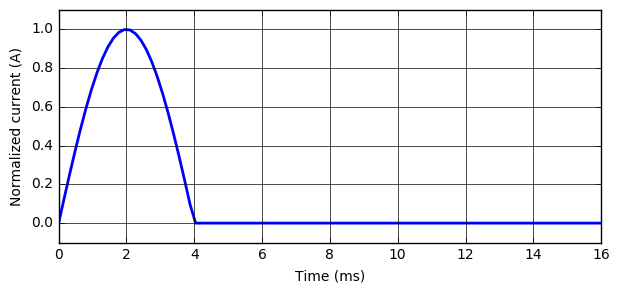

In [16]:
# x = np.linspace(0, 0.004+0.012, 100)
# current = np.sin(1./0.004*np.pi*x)
# current[x>0.004] = 0.
# fig = plt.figure(figsize = (7, 3))
# plt.plot(x*1e3, current, lw=2)
# plt.ylim(-0.1, 1.1)
# plt.grid(True, ls="-")
# plt.xlabel("Time (ms)")
# plt.ylabel("Normalized current (A)")

In [212]:
a = ["32", "34"]

In [447]:
map(float, a)

[32.0, 34.0]

In [448]:
map

<function map>